In [3]:
import cvxpy as cp
import numpy as np
import numpy.linalg as LA
from sklearn.utils import murmurhash3_32
from random import randint
import matplotlib.pyplot as plt
import copy
import time
import multiprocessing
from scipy.special import factorial
import math

import sklearn.datasets as d
import pickle
from scipy import optimize
import random

In [37]:
## Load dataset
with open('./Simulation_experiment/data.pickle', 'rb') as handle:
    data = pickle.load(handle)

## Evaluate the empirical covariance matrix 
mean_obs = np.apply_along_axis(np.mean, 0, data)
var_obs = (data - mean_obs).T@(data - mean_obs)/data.shape[0]

In [46]:
p = data.shape[1]
m = int(p*0.15)   ## m is the number of random projection vectors 

## S are the random gaussian vectors and normalize the norm of each vector
S = np.random.normal(0,1,p*m).reshape((p,m))
mean_S = np.apply_along_axis(LA.norm, 0, S)
S = S/mean_S

## Add each column of S to A
A = []
for i in range(S.shape[1]):
    A.append(S[:,i].reshape((p,1)))
    
## The projection of empirical covariance matrix   
b = np.diag(S.T @ var_obs @ S)

In [47]:
# X is the matrix to recover
X = cp.Variable((p,p), symmetric=True)
# The operator >> denotes matrix inequality.
constraints = [X >> 0]
constraints += [ A[i].T @ X @ A[i] == b[i]  for i in range(m)]

prob = cp.Problem(cp.Minimize(cp.trace(X)), constraints)

start = time.time()
prob.solve()
print("The optimal value is", prob.value)
print('execution time:', time.time()-start)

The optimal value is 428.57174427777335
execution time: 1061.9839823246002


In [ ]:
s, V = LA.eig(X.value)
print(np.trace(X.value), np.trace(var_obs))


## Eigenvalues of X should decay very fast (approximate low rank)
plt.plot(np.sort(s))
plt.show

In [45]:
with open('./Simulation_experiment/recovered_covariance_m%d.pickle' %m, 'wb') as handle:
    pickle.dump(X.value, handle)

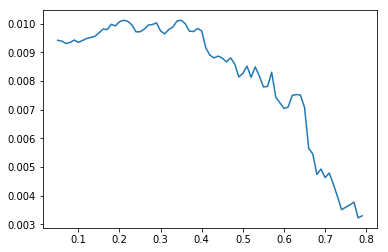

In [48]:
with open('./Simulation_experiment/true_covariance.pickle', 'rb') as handle:
    off_diag = pickle.load(handle)

var_off_diag = X.value[np.triu_indices(p, k=1)]

F1_score = []
precision_list = []
recall_list = []

threshold_list = np.arange(0.05, 0.8, 0.01)
for thres in threshold_list:
    positive_index = (np.abs(off_diag)>0)*1
    predict_positive_index = (np.abs(var_off_diag)>thres)
    fn = np.sum(positive_index*(1-predict_positive_index))
    tp = np.sum(predict_positive_index*positive_index)
    precision = tp/np.sum(predict_positive_index)
    recall = tp/(tp+fn)

    ## Deviation from the true covariance matrix
    F1_score += [2*precision*recall/(precision+recall)]
    precision_list += [precision]
    recall_list += [recall]
    
plt.plot(threshold_list, F1_score)
plt.show()